## Handwriting recognition

For this purpose we have used the MNIST data set, a collection of 70,000 handwriting samples of the numbers 0-9. Our challenge is to predict which number each handwritten image represents. Each image is 28x28 grayscale pixels, so we can treat each image as just a 1D array, or tensor, of 784 numbers. 

In [24]:
# IMPORTING THE LIBRARIES
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

In [25]:
# Prepare the data
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28*28)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1]
x_train, x_test = x_train / 255., x_test / 255.

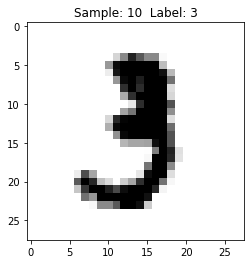

In [26]:
# Visualizing the data
%matplotlib inline

import matplotlib.pyplot as plt

def display_sample(num):
    #Print this sample's label 
    label = train_y[num] 
    
    #Reshape the 784 values to a 28x28 image
    image = train_x[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(10)

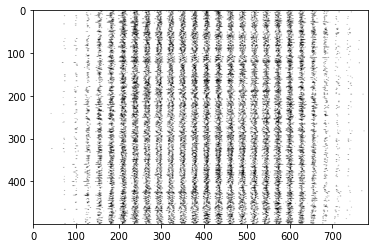

In [27]:
# Visualizing how the data is fed into input node of deep neural network
images = train_x[0].reshape([1,784])
for i in range(1, 500):
    images = np.concatenate((images, train_x[i].reshape([1,784])))
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

In [28]:
# Training parameters.
learning_rate = 0.001
training_steps = 3000
batch_size = 250
display_step = 100

# Network parameters.
n_hidden = 512 # Number of neurons.

In [29]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

In [30]:
# Setting up the Artificial Neural Network

# Store layers weight & bias
# A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

weights = {
    'h': tf.Variable(random_normal([num_features, n_hidden])),
    'out': tf.Variable(random_normal([n_hidden, num_classes]))
}
biases = {
    'b': tf.Variable(tf.zeros([n_hidden])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [31]:
# Create model.
def neural_net(inputData):
    # Hidden fully connected layer with 512 neurons.
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    # Apply sigmoid to hidden_layer output for non-linearity.
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

In [32]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [34]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [35]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 193.874695, Accuracy: 0.752000
Training epoch: 200, Loss: 102.630165, Accuracy: 0.884000
Training epoch: 300, Loss: 86.237984, Accuracy: 0.920000
Training epoch: 400, Loss: 105.880768, Accuracy: 0.888000
Training epoch: 500, Loss: 91.042755, Accuracy: 0.888000
Training epoch: 600, Loss: 76.001221, Accuracy: 0.908000
Training epoch: 700, Loss: 63.926022, Accuracy: 0.924000
Training epoch: 800, Loss: 75.767662, Accuracy: 0.928000
Training epoch: 900, Loss: 77.406837, Accuracy: 0.900000
Training epoch: 1000, Loss: 69.696777, Accuracy: 0.916000
Training epoch: 1100, Loss: 70.236099, Accuracy: 0.896000
Training epoch: 1200, Loss: 77.256088, Accuracy: 0.896000
Training epoch: 1300, Loss: 53.236362, Accuracy: 0.940000
Training epoch: 1400, Loss: 65.492622, Accuracy: 0.916000
Training epoch: 1500, Loss: 58.626827, Accuracy: 0.924000
Training epoch: 1600, Loss: 57.114105, Accuracy: 0.940000
Training epoch: 1700, Loss: 62.050282, Accuracy: 0.932000
Training epoch: 1800

In [37]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.930700


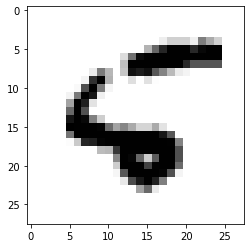

Original Labels: 5
Model prediction: 6


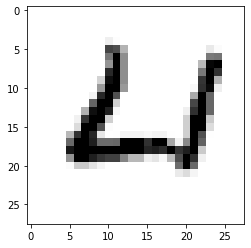

Original Labels: 4
Model prediction: 6


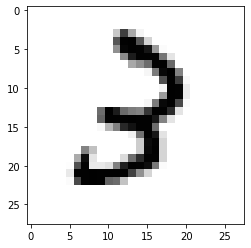

Original Labels: 3
Model prediction: 2


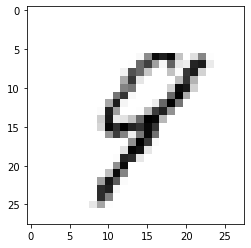

Original Labels: 9
Model prediction: 4


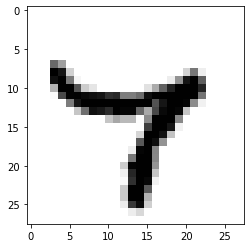

Original Labels: 7
Model prediction: 4


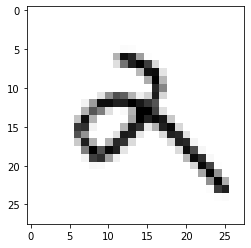

Original Labels: 2
Model prediction: 9


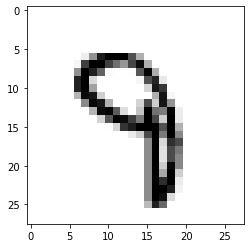

Original Labels: 9
Model prediction: 4


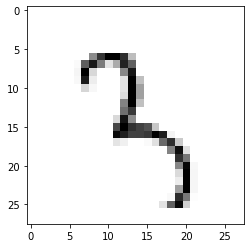

Original Labels: 3
Model prediction: 5


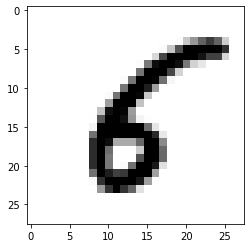

Original Labels: 6
Model prediction: 5


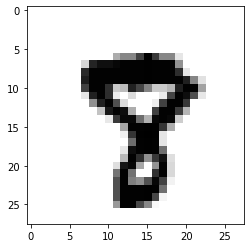

Original Labels: 8
Model prediction: 7


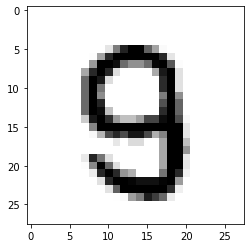

Original Labels: 9
Model prediction: 8


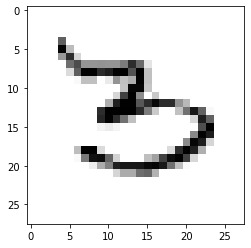

Original Labels: 3
Model prediction: 5


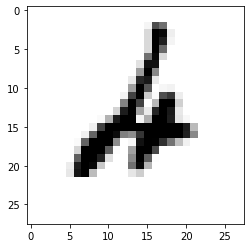

Original Labels: 4
Model prediction: 2


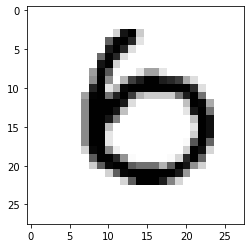

Original Labels: 6
Model prediction: 0


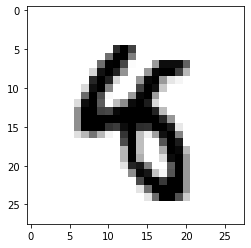

Original Labels: 8
Model prediction: 4


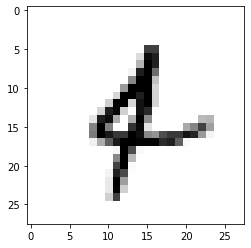

Original Labels: 4
Model prediction: 6


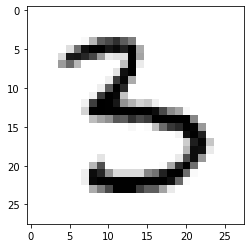

Original Labels: 3
Model prediction: 5


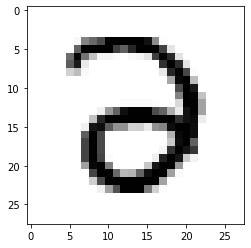

Original Labels: 2
Model prediction: 3


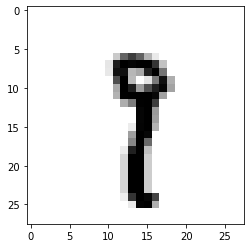

Original Labels: 9
Model prediction: 7


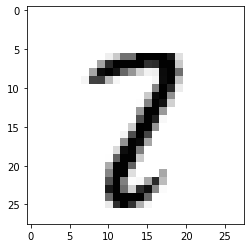

Original Labels: 2
Model prediction: 7


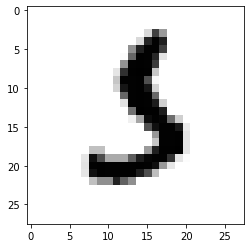

Original Labels: 5
Model prediction: 3


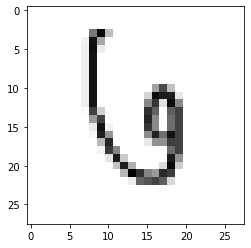

Original Labels: 6
Model prediction: 4


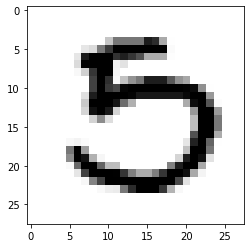

Original Labels: 5
Model prediction: 0


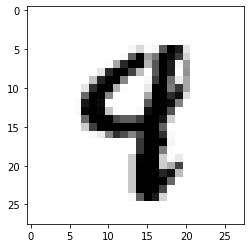

Original Labels: 9
Model prediction: 4


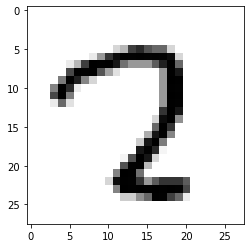

Original Labels: 2
Model prediction: 7


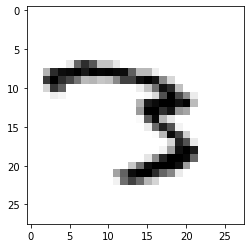

Original Labels: 3
Model prediction: 7


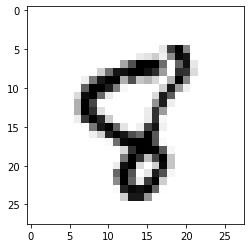

Original Labels: 8
Model prediction: 5


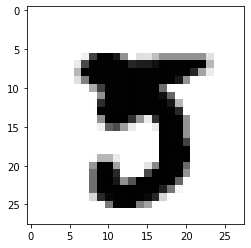

Original Labels: 5
Model prediction: 3


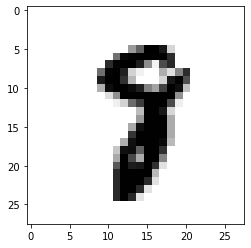

Original Labels: 8
Model prediction: 7


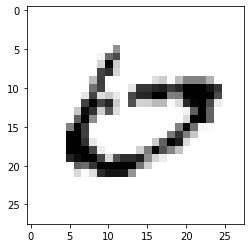

Original Labels: 6
Model prediction: 0


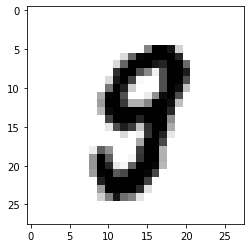

Original Labels: 9
Model prediction: 8


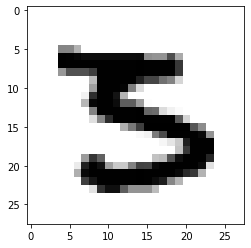

Original Labels: 3
Model prediction: 5


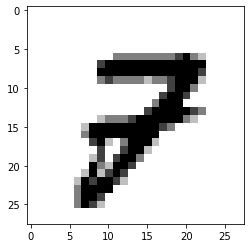

Original Labels: 7
Model prediction: 9


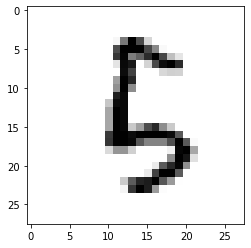

Original Labels: 5
Model prediction: 2


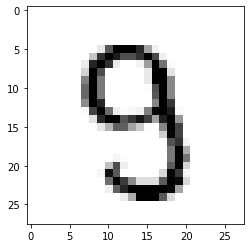

Original Labels: 9
Model prediction: 3


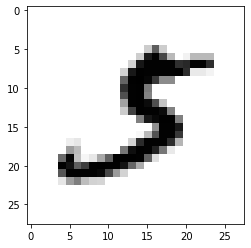

Original Labels: 5
Model prediction: 3


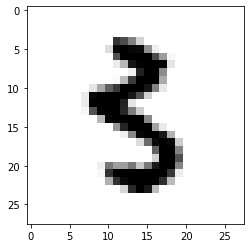

Original Labels: 3
Model prediction: 5


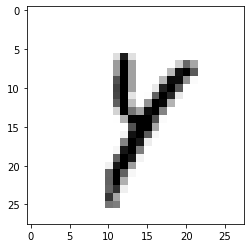

Original Labels: 4
Model prediction: 1


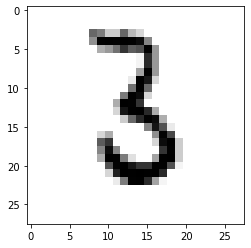

Original Labels: 3
Model prediction: 6


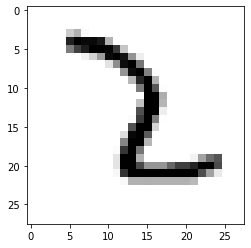

Original Labels: 2
Model prediction: 1


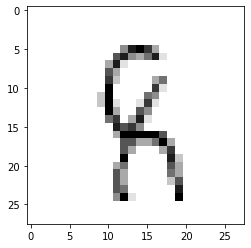

Original Labels: 8
Model prediction: 2


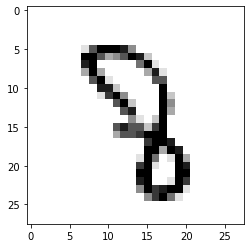

Original Labels: 8
Model prediction: 3


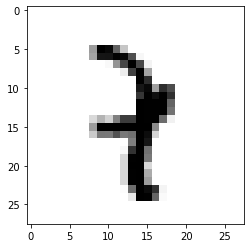

Original Labels: 7
Model prediction: 1


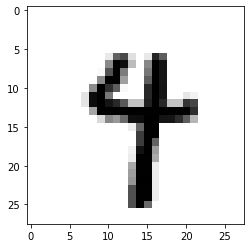

Original Labels: 4
Model prediction: 9


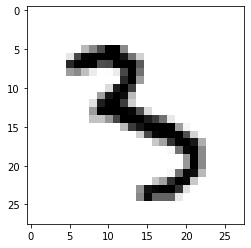

Original Labels: 3
Model prediction: 5


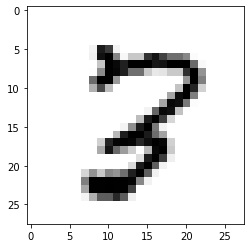

Original Labels: 3
Model prediction: 2


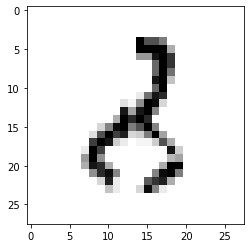

Original Labels: 8
Model prediction: 2


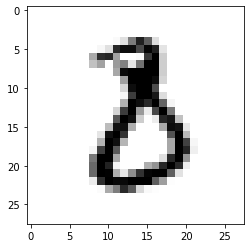

Original Labels: 8
Model prediction: 3


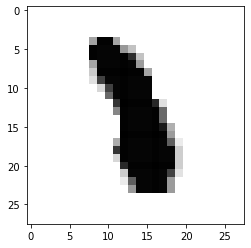

Original Labels: 1
Model prediction: 8


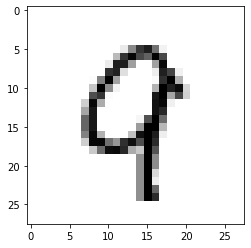

Original Labels: 9
Model prediction: 4


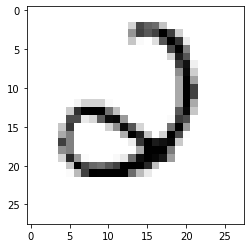

Original Labels: 2
Model prediction: 6


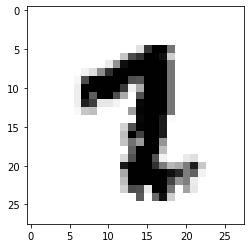

Original Labels: 2
Model prediction: 9


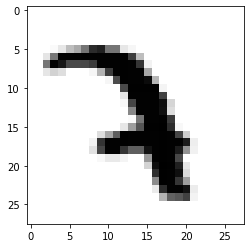

Original Labels: 7
Model prediction: 3


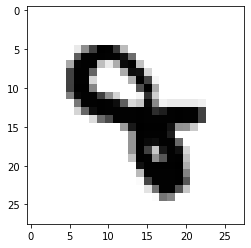

Original Labels: 8
Model prediction: 4


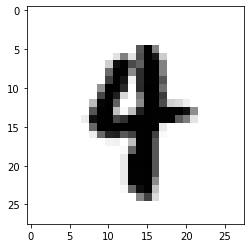

Original Labels: 4
Model prediction: 9


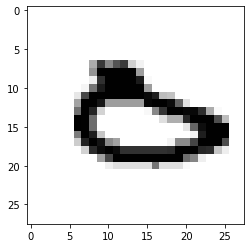

Original Labels: 0
Model prediction: 6


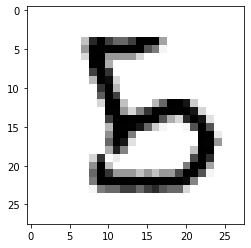

Original Labels: 5
Model prediction: 2


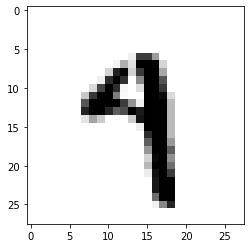

Original Labels: 4
Model prediction: 9


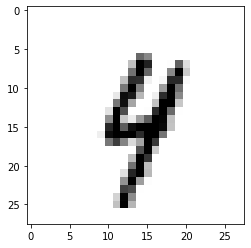

Original Labels: 4
Model prediction: 9


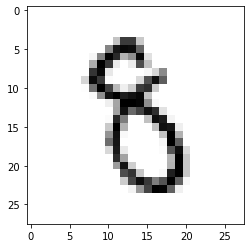

Original Labels: 8
Model prediction: 5


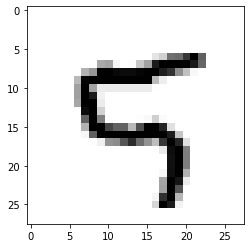

Original Labels: 5
Model prediction: 9


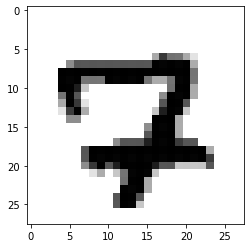

Original Labels: 7
Model prediction: 2


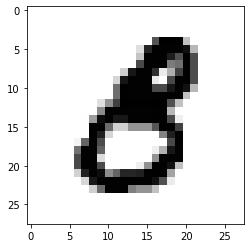

Original Labels: 8
Model prediction: 3


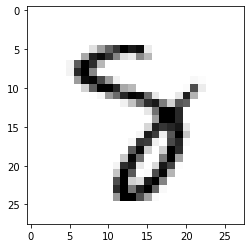

Original Labels: 8
Model prediction: 7


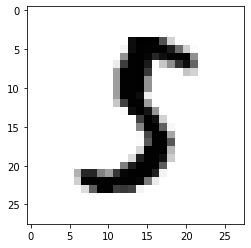

Original Labels: 5
Model prediction: 3


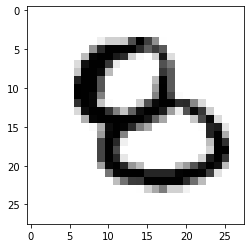

Original Labels: 8
Model prediction: 2


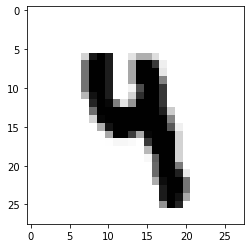

Original Labels: 4
Model prediction: 9


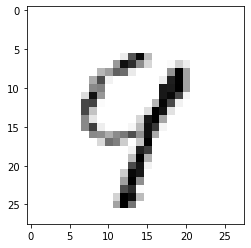

Original Labels: 9
Model prediction: 7


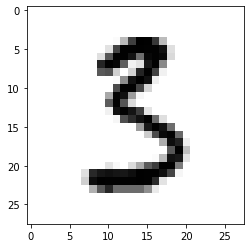

Original Labels: 3
Model prediction: 5


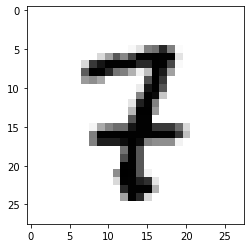

Original Labels: 7
Model prediction: 2


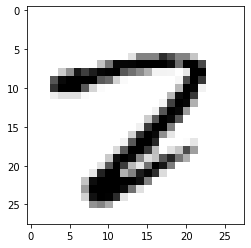

Original Labels: 2
Model prediction: 7


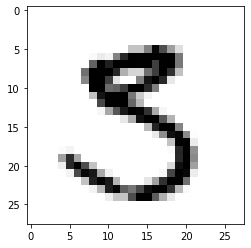

Original Labels: 3
Model prediction: 5


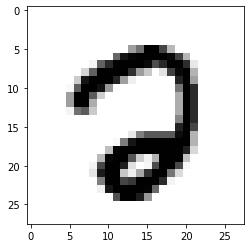

Original Labels: 2
Model prediction: 0


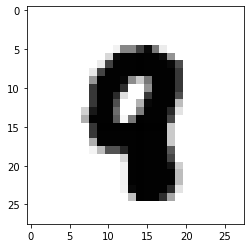

Original Labels: 8
Model prediction: 9


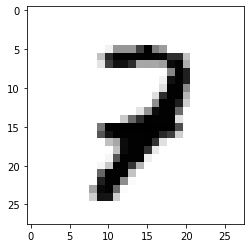

Original Labels: 7
Model prediction: 2


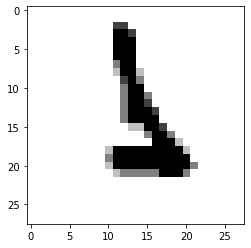

Original Labels: 1
Model prediction: 6


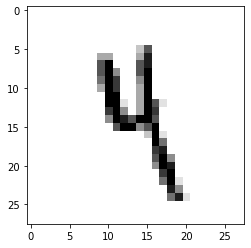

Original Labels: 4
Model prediction: 9


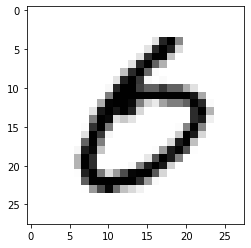

Original Labels: 6
Model prediction: 0


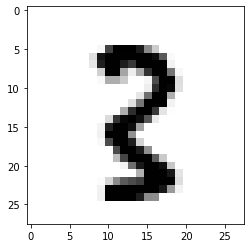

Original Labels: 3
Model prediction: 2


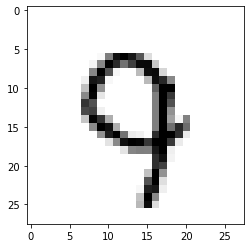

Original Labels: 9
Model prediction: 7


In [39]:
# Checking some images on which ann is giving wrong prediction

n_images = 1000
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)